# ESGF Virtual Aggregation - Computing ENSO

Remote data access to Virtual Analysis Ready Data (Virtual ARD) for climate datasets of the [ESGF](https://esgf.llnl.gov/).

In [1]:
import timeit
import zipfile

import numpy as np
import pandas as pd
import netCDF4
import xarray
import dask
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

dask.config.set(scheduler="processes")

%matplotlib inline

plt.rcParams['figure.figsize'] = 12, 6

# Introduction <a class="anchor" id="introduction"></a>

## Loading the inventory <a class="anchor" id="loading-the-inventory"></a>

Currently, the invetory is a CSV file which can be queried for locating the desired dataset. You may also inspect the [THREDDS catalog](https://hub.ipcc.ifca.es/thredds/catalog/esgeva/catalog.html).

In [2]:
df = pd.read_csv("https://hub.ipcc.ifca.es/thredds/fileServer/public/inventory.csv.zip")

# Find a dataset
subset = df.query("product == 'ScenarioMIP' & model == 'CNRM-CM6-1' & experiment == 'ssp245' & table == 'day' & variable == 'tas' & version == 'v20190410'")

# See available data nodes
subset[["location", "replica"]]

/tmp/ipykernel_41010/3879840114.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://hub.ipcc.ifca.es/thredds/fileServer/public/inventory.csv.zip")


location          replica
2124279  https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...              NaN
2124302  https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   aims3.llnl.gov
2124321  https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  esgf.ceda.ac.uk
2124329  https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  esgf.nci.org.au
2124348  https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...    esgf3.dkrz.de

## ENSO example <a class="anchor" id="enso"/>


https://github.com/esgf2-us/esgf-cookbook/blob/main/notebooks/enso-globus.ipynb

In [3]:
subset = pd.concat([
    df.query("model != 'CESM2-WACCM' & product == 'CMIP' & experiment == 'historical' & variable == 'areacello' & institution == 'NCAR' & replica.isnull()").groupby("model").last(),
    df.query("model != 'CESM2-WACCM' & product == 'CMIP' & experiment == 'historical' & variable == 'tos' & table == 'Omon' & institution == 'NCAR' & replica.isnull()").groupby("model").last(),
])

subset

location project  \
model                                                                        
CESM2            https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   CMIP6   
CESM2-FV2        https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   CMIP6   
CESM2-WACCM-FV2  https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   CMIP6   
CESM2            https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   CMIP6   
CESM2-FV2        https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   CMIP6   
CESM2-WACCM-FV2  https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   CMIP6   

                product institution  experiment subexperiment table  \
model                                                                 
CESM2              CMIP        NCAR  historical          None   Ofx   
CESM2-FV2          CMIP        NCAR  historical          None   Ofx   
CESM2-WACCM-FV2    CMIP        NCAR  historical          None   Ofx   
CESM2              CMIP        NCAR  historical          None  Omon   
CESM2-FV2          CMIP        NCAR  historical          None  Omon   
CESM2-WACCM-FV2    CMIP        NCAR  historical          None  Omon   

                  variable grid_label    version replica  
model                                                     
CESM2            areacello         gr  v20190514    None  
CESM2-FV2        areacello         gr  v20200226    None  
CESM2-WACCM-FV2  areacello         gr  v20200226    None  
CESM2                  tos         gr  v20190514    None  
CESM2-FV2              tos         gr  v20200226    None  
CESM2-WACCM-FV2        tos         gr  v20200226    None

In [4]:
%%time

areacello = subset.query("variable == 'areacello'")
tos = subset.query("variable == 'tos'")

ds = xarray.merge([
    xarray.concat([xarray.open_dataset(url)["areacello"].isel(variant_label=0).sel(lat=slice(-5,5), lon=slice(190,240))
                   for url in areacello["location"]], areacello.index),
    xarray.concat([xarray.open_dataset(url)["tos"].isel(variant_label=0).sel(lat=slice(-5,5), lon=slice(190,240))
                   for url in tos["location"]], tos.index)
]).drop_vars('variant_label')

ds

/home/zequi/miniconda3/envs/nc48/lib/python3.11/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/zequi/miniconda3/envs/nc48/lib/python3.11/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/zequi/miniconda3/envs/nc48/lib/python3.11/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


CPU times: user 341 ms, sys: 63.4 ms, total: 404 ms
Wall time: 12.6 s


<xarray.Dataset> Size: 12MB
Dimensions:    (lat: 10, lon: 50, model: 3, time: 1980)
Coordinates:
  * lat        (lat) float64 80B -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2.5 3.5 4.5
  * lon        (lon) float64 400B 190.5 191.5 192.5 193.5 ... 237.5 238.5 239.5
  * model      (model) object 24B 'CESM2' 'CESM2-FV2' 'CESM2-WACCM-FV2'
  * time       (time) object 16kB 1850-01-15 13:00:00.000007 ... 2014-12-15 1...
Data variables:
    areacello  (model, lat, lon) float64 12kB 1.233e+10 1.233e+10 ... 1.233e+10
    tos        (model, time, lat, lon) float32 12MB 29.27 29.19 ... 30.47 30.43
Attributes: (12/18)
    long_name:        Grid-Cell Area for Ocean Variables
    _CoordinateAxes:  variant_label lat lon
    cell_methods:     area: sum
    comment:          TAREA
    description:      Cell areas for any grid used to report ocean variables ...
    frequency:        fx
    ...               ...
    time_label:       None
    time_title:       No temporal dimensions ... fixed field
    title:            Grid-Cell Area for Ocean Variables
    type:             real
    units:            m2
    variable_id:      areacello

In [5]:
def calculate_enso(ds):

    # Subset the El Nino 3.4 index region
    dso = ds.where(
        (ds["lat"] < 5) &
        (ds["lat"] > -5) &
        (ds["lon"] > 190) &
        (ds["lon"] < 240),
        drop=True)

    # Calculate the monthly means
    gb = dso.tos.groupby('time.month')

    # Subtract the monthly averages, returning the anomalies
    tos_nino34_anom = gb - gb.mean(dim='time')

    # Determine the non-time dimensions and average using these
    non_time_dims = set(tos_nino34_anom.dims)
    non_time_dims.remove(ds.tos["time"].name)
    weighted_average = tos_nino34_anom.weighted(ds["areacello"]).mean(dim=list(non_time_dims))

    # Calculate the rolling average
    rolling_average = weighted_average.rolling(time=5, center=True).mean()
    std_dev = weighted_average.std()
    return rolling_average / std_dev

def add_enso_thresholds(da, threshold=0.4):

    # Conver the xr.DataArray into an xr.Dataset
    ds = da.to_dataset()

    # Cleanup the time and use the thresholds
    try:
        ds["time"]= ds.indexes["time"].to_datetimeindex()
    except:
        pass
    ds["tos_gt_04"] = ("time", ds.tos.where(ds.tos >= threshold, threshold).data)
    ds["tos_lt_04"] = ("time", ds.tos.where(ds.tos <= -threshold, -threshold).data)

    # Add fields for the thresholds
    ds["el_nino_threshold"] = ("time", np.zeros_like(ds.tos) + threshold)
    ds["la_nina_threshold"] = ("time", np.zeros_like(ds.tos) - threshold)

    return ds

enso_index = add_enso_thresholds(calculate_enso(ds).compute())
enso_index

/tmp/ipykernel_41010/2249447121.py:34: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  ds["time"]= ds.indexes["time"].to_datetimeindex()
/tmp/ipykernel_41010/2249447121.py:34: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds["time"]= ds.indexes["time"].to_datetimeindex()


<xarray.Dataset> Size: 111kB
Dimensions:            (time: 1980)
Coordinates:
  * time               (time) datetime64[ns] 16kB 1850-01-15T13:00:00.000007 ...
    month              (time) int64 16kB 1 2 3 4 5 6 7 8 ... 5 6 7 8 9 10 11 12
Data variables:
    tos                (time) float64 16kB nan nan -1.017 ... 1.347 nan nan
    tos_gt_04          (time) float64 16kB 0.4 0.4 0.4 0.4 ... 1.347 0.4 0.4
    tos_lt_04          (time) float64 16kB -0.4 -0.4 -1.017 ... -0.4 -0.4 -0.4
    el_nino_threshold  (time) float64 16kB 0.4 0.4 0.4 0.4 ... 0.4 0.4 0.4 0.4
    la_nina_threshold  (time) float64 16kB -0.4 -0.4 -0.4 ... -0.4 -0.4 -0.4

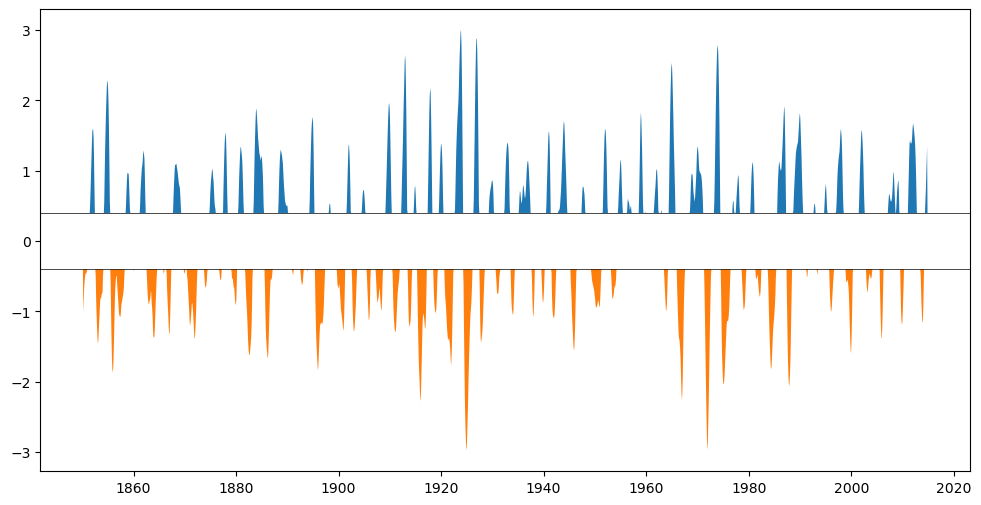

In [6]:
fig, ax = plt.subplots(1,1)

plt.axhline(y=0.4, color='black', linestyle='-', linewidth=.5)
plt.axhline(y=-0.4, color='black', linestyle='-', linewidth=.5)

plt.fill_between(enso_index["time"], enso_index["tos_gt_04"].data, 0.4)
plt.fill_between(enso_index["time"], enso_index["tos_lt_04"].data, -0.4)

You may export the results to a dataset so the workflow can be reproduced.

In [7]:
# ds.to_netcdf("enso.nc")